<a href="https://colab.research.google.com/github/duyvm/funny_stuff_with_llm/blob/main/learning-rag/Demo_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain[openai] langchain-core beautifulsoup4 langchain-pinecone gradio

Demo agenda:

- Part 1: QA system with vector database

  - Part 1-1: Basic QA RAG

  - Part 1-2: Improvement techniques

- Part 2: QA system with SQL data

  - Part 2-1: using predefined workflow

  - Part 2-2: using simple agent

# Import libraries and helper functions

In [2]:
import bs4
import os
import gradio as gr

from langchain import hub
from langchain.chat_models import init_chat_model

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

from langchain_openai import OpenAIEmbeddings

from langchain_core.documents import Document
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.prompts import ChatPromptTemplate

from langchain_pinecone import PineconeVectorStore

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.checkpoint.memory import MemorySaver

from typing_extensions import List, TypedDict, Annotated
from IPython.display import Image, display

from google.colab import userdata
from pinecone import Pinecone, ServerlessSpec

def start_ui(graph, config, share=False, debug=True):
    """
    Start the Gradio UI for the ChatBot
    """

    # streaming response method
    async def stream_fn(user_input, history):

        state = {
            "question": user_input,
        }

        bot_reply = ""

        async for chunk, metadata in graph.astream(
            state,
            config,
            stream_mode="messages",
        ):
            if metadata["stream"]:
                bot_reply += chunk.content
                yield bot_reply

    # Start the interface (it will print a link you can click)
    chat_ui = gr.ChatInterface(
        fn=stream_fn,
        title="🤖 Demo RAG",
        type="messages",
    )

    chat_ui.launch(share=share, debug=debug)

def load_data(urls, vector_store):
    """
    Parse data from webpage and insert into vector store
    """
    # load new url, splint and index it
    web_loader = WebBaseLoader(
            web_paths=urls,
            bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("mw-content-ltr mw-parser-output", "mw-page-title-main")
            )
        )
    )

    documents = web_loader.load()

    # split the documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_documents(documents)

    # Pinecorn API has limit message size of 4MB
    # Batch insert the chunks into the vector store
    batch_size = 100
    for i in range(0, len(all_splits), batch_size):
        splits_batch = all_splits[i:i + batch_size]
        vector_store.add_documents(splits_batch)

### Load api keys into environment

In [3]:
PROJECT_NAME = "demo-rag"

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = f"{PROJECT_NAME}"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Part 1: QA system with vector database (semantic search)

## Part 1-1: Basic QA RAG

- Knowledge base: a vector db (`pinecone`) for storing documents

- Llm model: `gpt-4o-mini` of `openai`

- User interacts with chatbot

- Basic functionalities:

  1. Understand user's question

  2. Search for answer from knowledge base

  3. Answer user's question

### Initialize model

In [4]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

### Create vector db

In [5]:
# In memory db
# vector_store = InMemoryVectorStore(embeddings)
pc = Pinecone(api_key=userdata.get('PINECORN_API_KEY'))

# Create Index on pinecorn for text-embedding-3-large
index_name = PROJECT_NAME

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

### Load documents

In [6]:
# load data from urls
urls = [
    "https://ja.wikipedia.org/wiki/%E3%81%93%E3%81%AE%E7%B4%A0%E6%99%B4%E3%82%89%E3%81%97%E3%81%84%E4%B8%96%E7%95%8C%E3%81%AB%E7%A5%9D%E7%A6%8F%E3%82%92!",
    "https://en.wikipedia.org/wiki/Alice_in_Chains",
    "https://en.wikipedia.org/wiki/Alanis_Morissette"
]

load_data(urls, vector_store)

### Build graph

In [7]:
# define state of langgraph
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# 1st step: retrieve documents in vector db
def retrieve(state: State) -> dict:
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

# 2nd step: generate response to user's question based on retrieved context
def generate(state: State):
    """
    Generate the response based on context
    """
    doc_content = "\n\n".join([doc.page_content for doc in state["context"]])
    # prompt_with_context = rag_prompt.invoke(input={"context": doc_content, "question": state["question"]})
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, just say that you "
        "don't know, don't try to make up an answer. Use three sentences "
        "maximum and keep the answer concise. "
        "\n\n"
        f"{doc_content}"
    )
    prompt_with_context = [SystemMessage(content=system_message)] + [HumanMessage(content=state["question"])]
    answer = llm.invoke(prompt_with_context)
    return {"answer": answer.content}

# add memory
memory = MemorySaver()

# compile the graph and test
graph_builder = StateGraph(State)
graph_builder.add_node(retrieve.__name__, retrieve, metadata={"stream": False})
graph_builder.add_node(generate.__name__, generate, metadata={"stream": True})
graph_builder.set_entry_point(retrieve.__name__)
graph_builder.add_edge(retrieve.__name__, generate.__name__)
graph_builder.add_edge(generate.__name__, END)
graph = graph_builder.compile(checkpointer=memory)

#### Visualize the graph

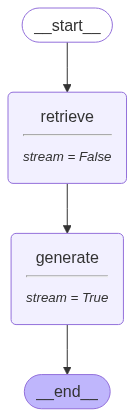

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
start_ui(graph, {"configurable": {"thread_id": "duyvm123"}}, share=False, debug=True)

### Testing around with chatbot

- Ask something in our documents in Japanese/English/Vietnamese

- Ask something new (`Albus Dumbledore`)

### Add more data

- Add data about Albus Dumbledore and Harry Porter

- Try asking: `who is the teen that have a lightning shaped scar on his forehead? His parent are murder when he was just a boy and he can talk to snake?`

In [10]:
# load data from urls
urls = [
    "https://en.wikipedia.org/wiki/Albus_Dumbledore",
    "https://en.wikipedia.org/wiki/Harry_Potter_(character)",
    "https://en.wikipedia.org/wiki/Hermione_Granger",
    "https://en.wikipedia.org/wiki/Ron_Weasley",
    "https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows",
    "https://en.wikipedia.org/wiki/Harry_Potter_and_the_Goblet_of_Fire",
    "https://en.wikipedia.org/wiki/Harry_Potter_and_the_Order_of_the_Phoenix",

]

load_data(urls, vector_store)

### 🧠 Conclude

#### **Goods**

👍 The app can understand multi-languages

👍 The app can understand the variants of the question

#### **Need improvement**

🤔 We are considering user's question is the whole information for searching in vector db. It can lead to retrieving incorrect informations if the actual information that we want is too small consider to the length of question. How to seperate the actual relevant information piece for searching with the rest in the question.

🤔 The accuracy of answer depends a lot on retrieved informations. It can be tricky when stored information and provided information (in question) is not in the same language

#### **Some solutions**

- Query analysis

- Query re-writing

- Vector DB with metadata filters

- Agentic approach

## Part 1-2: Improvements

- Add a query analysis step at the beginning: leverage llm to understand user's intention and extract query keywords

  - With this, we can remove irrelevant informations when searching with vector db.

  - We also directly response to user if it is not a question.

- This implementation is basic and for introduction only. In practice, we should use pre-defined `tool` or agentic approach

### Create nodes

- Add new nodes and condition check function

- Add a field `query` and `is_query` to state

In [11]:
# define state of langgraph
class StateWithQuery(TypedDict):
    question: str
    query: str
    context: List[Document]
    answer: str
    is_query: bool

# 1st
def query_or_response(state: StateWithQuery):
    """
    Generatate query for retrieval or response directly to user
    """
    system_message = (
        "You are an assistant for query-analysis task. "
        "You receive the input from user. You analyze the input. "
        "If it is a question, you pick only relevant query key-words from that question, "
        "and remove un-needed information and DO NOT ADD any word that not from question."
        "If it is not a question, you return with 'NA'"
        "\n\n"
    )
    prompt_with_context = [SystemMessage(content=system_message)] + [HumanMessage(content=state["question"])]
    answer = llm.invoke(prompt_with_context)

    if answer.content.upper() == "NA":
        state["is_query"] = False
        state["query"] = ""
    else:
        state["is_query"] = True
        state["query"] = answer.content

    return state

# 2nd
def retrieve(state: StateWithQuery) -> dict:
    retrieved_docs = vector_store.similarity_search(state["query"])
    return {"context": retrieved_docs}

# 3rd
def generate(state: StateWithQuery):
    """
    Generate the response based on context
    """
    doc_content = "\n\n".join([doc.page_content for doc in state["context"]])
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, just say that you "
        "don't know, don't try to make up an answer. Use three sentences "
        "maximum and keep the answer concise. "
        "\n\n"
        f"{doc_content}"
    )
    prompt_with_context = [SystemMessage(content=system_message)] + [HumanMessage(content=state["query"])]
    answer = llm.invoke(prompt_with_context)
    return {"answer": answer.content}

def i_don_know(state: StateWithQuery):
    """
    Return I don't know if the answer is not available
    """
    return {"messages": [AIMessage(content="I don't know about that. Please ask another question.")]}

def is_query(state: StateWithQuery):
    if state["is_query"]:
        return retrieve.__name__
    else:
        return i_don_know.__name__

### Build graph

In [12]:
memory2 = MemorySaver()

graph_builder = StateGraph(StateWithQuery)

# Add each node
graph_builder.add_node(query_or_response.__name__, query_or_response, metadata={"stream": False})
graph_builder.add_node(retrieve.__name__, retrieve, metadata={"stream": False})
graph_builder.add_node(generate.__name__, generate, metadata={"stream": True})
graph_builder.add_node(i_don_know.__name__, i_don_know, metadata={"stream": True})

# Start from query_or_response
graph_builder.add_edge(START, query_or_response.__name__)

# Conditional edge after query_or_response
graph_builder.add_conditional_edges(
    query_or_response.__name__,
    is_query,
    {
        retrieve.__name__: retrieve.__name__,
        i_don_know.__name__: i_don_know.__name__,
    },
)

# Continue only if retrieve ran
graph_builder.add_edge(retrieve.__name__, generate.__name__)
graph_builder.add_edge(generate.__name__, END)
graph_builder.add_edge(i_don_know.__name__, END)

improved_graph = graph_builder.compile(checkpointer=memory2)

### Visualize graph

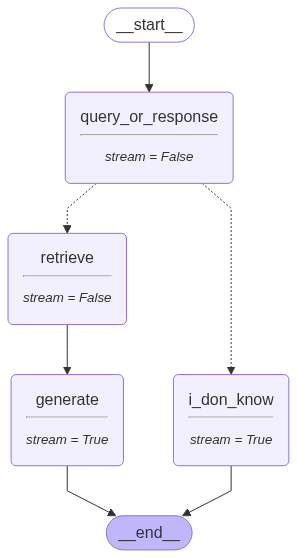

In [13]:
display(Image(improved_graph.get_graph().draw_mermaid_png()))

In [14]:
start_ui(improved_graph, {"configurable": {"thread_id": "duyvm456"}}, share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


### 🧠 Conclude

#### **Goods**

👍 The app now can understand user's question and pick the right keyword for querying

#### **Even better**

- Agentic approach

# Part 2: RAG with relational data (structured data search)

- Knowledge base: normal relational database

  - In this example I use serverless db `sqlite` with [`Chinook` db](https://www.sqlitetutorial.net/sqlite-sample-database/)

- Llm model: `gpt-4o-mini` of `openai`

- User interacts with chatbot

- Basic functionalities:

  1. Understand user's question

  2. Transform to SQL query

  3. Execute query

  4. Answer user's question based on result of query

### Download and build the database

- Guide here: [2 Sample Databases for SQLite](https://database.guide/2-sample-databases-sqlite/)

In [15]:
!sudo apt-get install sqlite3
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
sqlite3 is already the newest version (3.37.2-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


### Let take a look at the Chinook DB

In [16]:
# load the database and testing
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print()
print(db.get_usable_table_names())
print()
print(db.get_table_info())

sqlite

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(2

#### Visualize ER diagram

In [17]:
!pip install -qU schemadisplay-magic

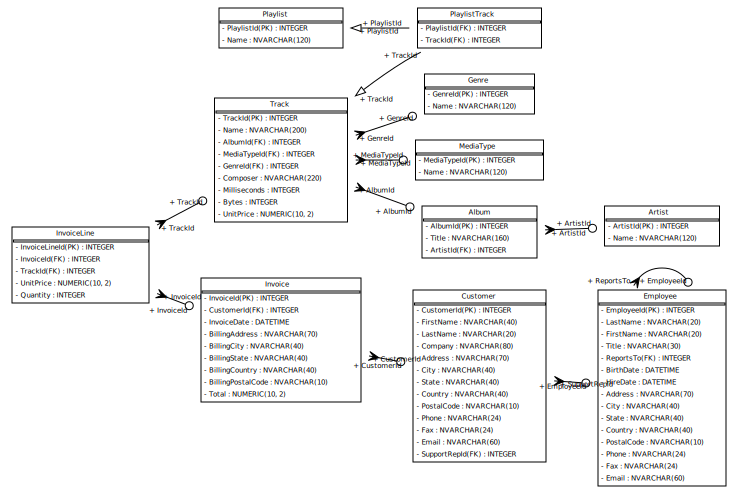

In [18]:
%load_ext schemadisplay_magic
%schema --connection_string sqlite:///Chinook.db

### Initialize model

In [19]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

### Define prompts (important)

- Define the prompt tempalte requesting llm generating SQL query

- The parameter like `dialect`, `table_info`, `top_k` are inserted later

- In this example `table_info`is taken directly using `CREATE TABLE` statement form db. It is useful if we added description for each table and column. In this case

  - Hybrid approach: `Vector DB` + `SQL`

In [20]:
# prompt template
system_message = """
Given an input question, create a syntactically correct {dialect} query to run
to help find the answer. Unless the user specifies in his question a specific
number of examples they wish to obtain, always limit your query to at most {top_k}
results. You can order the results by a relevant column to return the most
interesting examples in database

Never query for all the columns from a specific table, only ask for the few relevant
columns given the question.

Pay attention to use only the column names that you can see in the schema description.
Be careful to not query for columns that do not exist. Also, pay attention to which
column is in which table.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to run
to help find the answer. Unless the user specifies in his question a specific
number of examples they wish to obtain, always limit your query to at most {top_k}
results. You can order the results by a relevant column to return the most
interesting examples in database

Never query for all the columns from a specific table, only ask for the few relevant
columns given the question.

Pay attention to use only the column names that you can see in the schema description.
Be careful to not query for columns that do not exist. Also, pay attention to which
column is in which table.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


### Build node and graph

- Same as previous demo

- For directly executing SQL, we use pre-defined `QuerySQLDatabaseTool` tool.

#### More about tools

- [tools](https://python.langchain.com/docs/concepts/tools/): basically, a implement, used to carry out a particular function (in this case is execution of SQL query). Few db related tools:

  - `SQLDatabaseToolkit`: set of tools related to SQL Db

  - `QuerySQLDatabaseTool`: run query to target db

In [21]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

for tool in SQLDatabaseToolkit(db=db, llm=llm).get_tools():
    print(f"{tool.name}: {tool.description}")

print()
print("used tool in this demo")
print(f"{QuerySQLDatabaseTool(db=db).name}: {QuerySQLDatabaseTool(db=db).description}")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.
sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!

used tool in this demo
sql_db_query: 
    Execute a SQL query against the database and get back the result..
    If the

In [22]:
# application state
class SQLExampleState(TypedDict):
    question: str           # user's question
    query: str              # generated SQL query
    result: str             # result of SQl query
    answer: str             # final answer

# query output
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

# 1st node
def write_query(state: SQLExampleState):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "input": state["question"],
            "dialect": db.dialect,
            "table_info": db.get_table_info(),
            "top_k": 10,
        }
    )

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}


# 2nd node
def execute_query(state: SQLExampleState):
    """Execute the generated SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# 3rd node
def generate_answer(state: SQLExampleState):
    """Answer the question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )

    response = llm.invoke(prompt)
    return {"answer": response.content}

### Build graph

In [23]:
graph_builder = StateGraph(SQLExampleState)

graph_builder.add_node(write_query.__name__, write_query, metadata={"stream": False})
graph_builder.add_node(execute_query.__name__, execute_query, metadata={"stream": False})
graph_builder.add_node(generate_answer.__name__, generate_answer, metadata={"stream": True})  # streams only this node
graph_builder.set_entry_point(write_query.__name__)
graph_builder.add_edge(write_query.__name__, execute_query.__name__)
graph_builder.add_edge(execute_query.__name__, generate_answer.__name__)

graph_for_sql_query = graph_builder.compile()

### Visualize graph

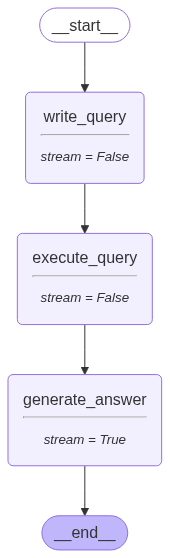

In [24]:
display(Image(graph_for_sql_query.get_graph().draw_mermaid_png()))

### Test it

- Which country's customers spent the most?

- what album have most tracks?

- Who am I?

In [25]:
start_ui(graph_for_sql_query, {"configurable": {"thread_id": "duyvm789"}}, share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


### 🧠 Conclude

#### **Goods**

👍 The app can understand multi-languages

👍 The app can understand the variants of the question

#### **Need improvement**

🤔 We are considering user's question is the whole information for searching in vector db. It can lead to retrieving incorrect informations if the actual information that we want is too small consider to the length of question. How to seperate the actual relevant information piece for searching with the rest in the question.

🤔 The accuracy of answer depends a lot on retrieved informations. It can be tricky when stored information and provided information (in question) is not in the same language

#### **Some solutions**

- Query analysis

- Query re-writing

- Vector DB with metadata filters

- Agentic approach